<a href="https://colab.research.google.com/github/nithya251006/project1/blob/main/NITHYA_BAGAVATHI_P_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✔ Dataset Loaded Successfully!

   protocol  flow_duration  total_forward_packets  total_backward_packets  \
0        17           2468                      4                       0   
1        17            133                      4                       0   
2        17          33509                    200                       0   
3        17         288495                    200                       0   
4        17              9                      2                       0   

   total_forward_packets_length  total_backward_packets_length  \
0                        1580.0                            0.0   
1                        5888.0                            0.0   
2                       88000.0                            0.0   
3                       88000.0                            0.0   
4                        2062.0                            0.0   

   forward_packet_length_mean  backward_packet_length_mean  \
0                       395.0                 

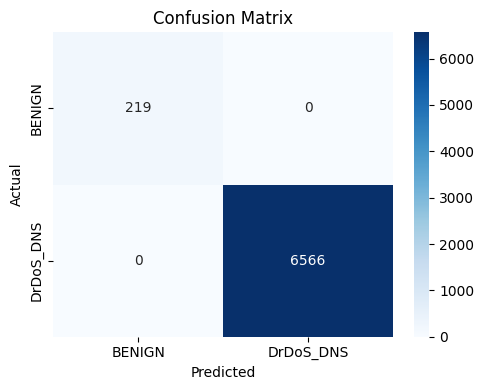

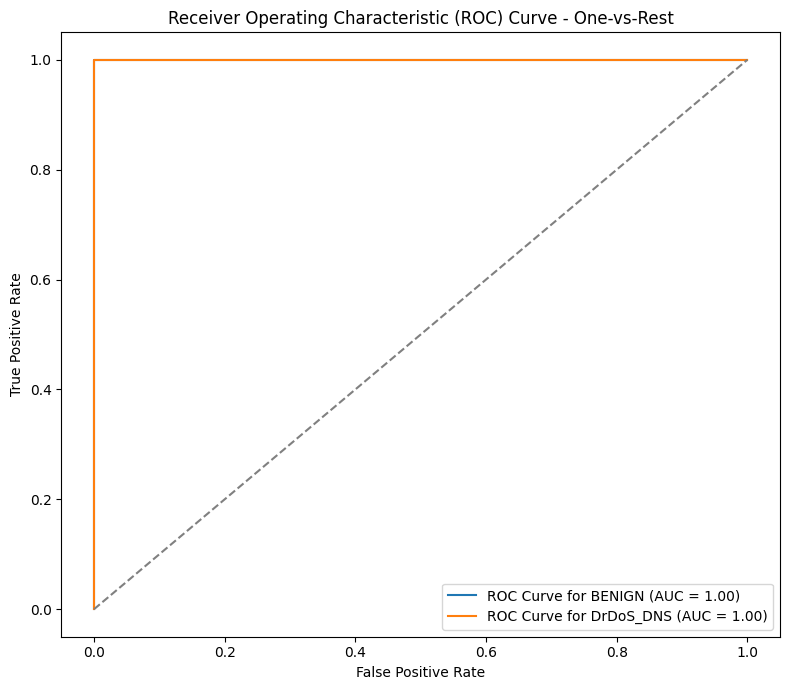

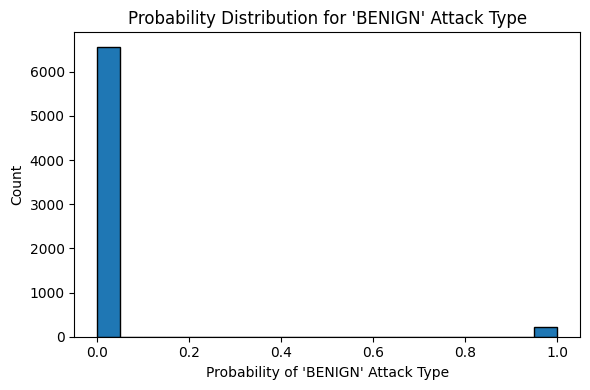


=== SAMPLE PREDICTION ===
Predicted Attack Type : BENIGN
Class Probabilities:
  BENIGN: 0.8850
  DrDoS_DNS: 0.1150


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, roc_curve, auc
)

df = pd.read_csv("/content/sample_data/DrDoS_DNS.csv.zip", encoding='latin1')

print("✔ Dataset Loaded Successfully!\n")
print(df.head())

# The 'fraud' column was not found. Please identify the correct target variable.
# X = df.drop("fraud", axis=1)
# y = df["fraud"]

print("Available columns in df:")
print(df.columns)

# Once you identify the correct target column, you can uncomment and adjust these lines:
# X = df.drop("YOUR_TARGET_COLUMN", axis=1)
# y = df["YOUR_TARGET_COLUMN"]

# numeric_cols = X.select_dtypes(include=['int64','float64']).columns
# categorical_cols = X.select_dtypes(include=['object']).columns

# Assuming 'DEALSIZE' is the target variable for classification.
# Please adjust 'DEALSIZE' to your actual target column if it's different.
X = df.drop("label", axis=1)
y = df["label"]

numeric_cols = X.select_dtypes(include=['int64','float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", RandomForestClassifier(n_estimators=200, random_state=42))
])


x_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(x_train, y_train)
print("\n✔ Model Training Completed!")

y_pred = model.predict(X_test)
y_prob_multiclass = model.predict_proba(X_test)

print("\n============= MODEL PERFORMANCE ============")
print("Accuracy  :", accuracy_score(y_test, y_pred))
print("Precision :", precision_score(y_test, y_pred, average='weighted'))
print("Recall    :", recall_score(y_test, y_pred, average='weighted'))

# Fix for ValueError in roc_auc_score with multi_class='ovr' for binary case
# Explicitly handle binary classification for ROC-AUC
if len(model.classes_) == 2:
    le = LabelEncoder()
    y_test_encoded = le.fit_transform(y_test)
    # Assuming the second class in model.classes_ is the positive class (e.g., 'DrDoS_DNS')
    # You can verify this with model.classes_ and le.classes_
    positive_class_index = 1 # Assuming 'DrDoS_DNS' is at index 1 or is considered positive
    # If you want to dynamically find the index of a specific class (e.g., 'DrDoS_DNS'):
    if 'DrDoS_DNS' in model.classes_:
        positive_class_index = list(model.classes_).index('DrDoS_DNS')

    y_prob_positive_class = y_prob_multiclass[:, positive_class_index]
    print("ROC-AUC   :", roc_auc_score(y_test_encoded, y_prob_positive_class))
else:
    # For true multiclass (more than 2 classes), the original approach should work.
    print("ROC-AUC   :", roc_auc_score(y_test, y_prob_multiclass, multi_class='ovr', average='weighted'))

print("==============================================\n")

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# The general approach for multiclass ROC curves remains valid if you have >2 classes.

# Get the unique classes from the fitted model, which determines the order of probabilities
classes = model.classes_

plt.figure(figsize=(8, 7))

# Plot ROC curve for each class using One-vs-Rest approach
# This loop structure is correct and robust for plotting individual OVR ROC curves
# even if roc_auc_score for combined OVR struggled.
for i, class_name in enumerate(classes):
    # Binarize the true labels for the current class (1 if it's the class, 0 otherwise)
    y_test_binarized = (y_test == class_name).astype(int)

    # Get the predicted probabilities for the current class from the multiclass probability array
    y_score = y_prob_multiclass[:, i]

    fpr, tpr, _ = roc_curve(y_test_binarized, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"ROC Curve for {class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve - One-vs-Rest")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Assuming you want to plot the probability distribution for one of the classes, e.g., 'Small'
# You can change 'Small' to 'Medium' or 'Large' as needed.

# Get the index of the 'Small' class from the model's classes
# The current dataset does not have 'Small', 'Medium', 'Large' classes. Instead, it has attack types.
# Let's pick the first class for demonstration.
if len(model.classes_) > 0:
    first_class_name = model.classes_[0]
    first_class_idx = 0

    plt.figure(figsize=(6,4))
    plt.hist(y_prob_multiclass[:, first_class_idx], bins=20, edgecolor="black")
    plt.title(f"Probability Distribution for '{first_class_name}' Attack Type")
    plt.xlabel(f"Probability of '{first_class_name}' Attack Type")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# Corrected sample_data based on the actual features used for training (from X DataFrame)
sample_data = {
    'protocol': 17,
    'flow_duration': 100000,
    'total_forward_packets': 10,
    'total_backward_packets': 5,
    'total_forward_packets_length': 500,
    'total_backward_packets_length': 200,
    'forward_packet_length_mean': 50.0,
    'backward_packet_length_mean': 40.0,
    'forward_packets_per_second': 100.0,
    'backward_packets_per_second': 50.0,
    'forward_iat_mean': 10000.0,
    'backward_iat_mean': 20000.0,
    'flow_iat_mean': 5000.0,
    'flow_packets_per_seconds': 150.0,
    'flow_bytes_per_seconds': 700.0
}
sample = pd.DataFrame([sample_data])

pred = model.predict(sample)[0]
probabilities = model.predict_proba(sample)[0] # Get all probabilities for the single sample

print("\n=== SAMPLE PREDICTION ===")
print("Predicted Attack Type :", pred)
print("Class Probabilities:")
for i, class_name in enumerate(model.classes_):
    print(f"  {class_name}: {probabilities[i]:.4f}")